In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
#opening the data file in read mode
df = pd.read_csv('/content/drive/My Drive/Sentiment_Analysis_Dataset.tsv', sep='\t')
print(df)


            id  sentiment                                             review
0       5814_8          1  With all this stuff going down at the moment w...
1       2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2       7759_3          0  The film starts with a manager (Nicholas Bell)...
3       3630_4          0  It must be assumed that those who praised this...
4       9495_8          1  Superbly trashy and wondrously unpretentious 8...
...        ...        ...                                                ...
24995   3453_3          0  It seems like more consideration has gone into...
24996   5064_1          0  I don't believe they made this film. Completel...
24997  10905_3          0  Guy is a loser. Can't get girls, needs to buil...
24998  10194_3          0  This 30 minute documentary Buñuel made in the ...
24999   8478_8          1  I saw this movie as a child and it broke my he...

[25000 rows x 3 columns]


In [ ]:
reviews=df.iloc[:,2].values
labels=df.iloc[:,1].values


In [ ]:
#parsing html
from bs4 import BeautifulSoup
import re

def parseHtml(html):
  soup = BeautifulSoup(html, 'html.parser')
  return soup.get_text()

def removeDigits(string):
  for i in range(10):
    string=string.replace(str(i),' ')
  return string

#removing html
reviews=list(map(parseHtml, reviews))

#removing digits
reviews=list(map(removeDigits, reviews))


In [ ]:
#tokenizing
import nltk
nltk.download('punkt')
tokenizedText=[nltk.word_tokenize(item) for item in reviews]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#removing punctuation
punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
tokenizedText= [[word for word in review if word not in punc] for review in tokenizedText]


In [ ]:
import numpy as np
#splitting the Dataset into train and test set
totalRows=np.shape(tokenizedText)[0]

splitRatio=0.75
splitPoint=int(splitRatio*totalRows)

trainReviews=tokenizedText[:splitPoint]
trainLabels=labels[:splitPoint]
testReviews=tokenizedText[splitPoint:]
testLabels=labels[splitPoint:]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
#learning word embeddings on training data using Gensim library
from gensim.models import Word2Vec, KeyedVectors
import nltk

embeddingsSize=128
model=Word2Vec(trainReviews, size=embeddingsSize, window=5, min_count=1, workers=4)
######################Training of Word Embeddings Vector Completed#########

In [ ]:
import numpy as np
def getVectors(dataset):
  singleDataItemEmbedding=np.zeros(embeddingsSize)
  vectors=[]
  for dataItem in dataset:
    wordCount=0
    for word in dataItem:
      if word in model.wv.vocab:
        singleDataItemEmbedding=singleDataItemEmbedding+model.wv[word]
        wordCount=wordCount+1

    singleDataItemEmbedding=singleDataItemEmbedding/wordCount
    vectors.append(singleDataItemEmbedding)
  return vectors

trainReviewVectors=getVectors(trainReviews)
testReviewVectors=getVectors(testReviews)

In [ ]:
#Let's define a function that can display the accuracy, F1-score, label-wise precision, recall, etc. of each classifier

from sklearn.metrics import accuracy_score
#add path of google drive to environment variable to load python files from google drive
import sys
sys.path.insert(1, "/content/drive/My Drive/nlp assignments/assignment 4")
from visualization import plot_confusion_matrix_from_data
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score

def printResults(y_true, y_predicted):
  print("Accuracy= ", accuracy_score(y_true, y_predicted))

  columns=['false', 'true']
  plot_confusion_matrix_from_data(y_true, y_predicted, columns)

  precision, recall, fscore, support = score(y_true, y_predicted)

  print('###########################################')
  print('precision: {}'.format(precision))
  print('recall: {}'.format(recall))
  print('fscore: {}'.format(fscore))
  print('support: {}'.format(support))
  print('###########################################3')

  print('Macro F1 ',f1_score(y_true, y_predicted, average='macro'))

  print('Micro F1 ', f1_score(y_true, y_predicted, average='micro'))



####################RESULTS OF NAIVE BAYES CLASSIFIER##################
Accuracy=  0.63264


/content/drive/My Drive/nlp assignments/assignment 4/visualization.py:165: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/content/drive/My Drive/nlp assignments/assignment 4/visualization.py:166: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/content/drive/My Drive/nlp assignments/assignment 4/visualization.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/content/drive/My Drive/nlp assignments/assignment 4/visualization.py:169: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


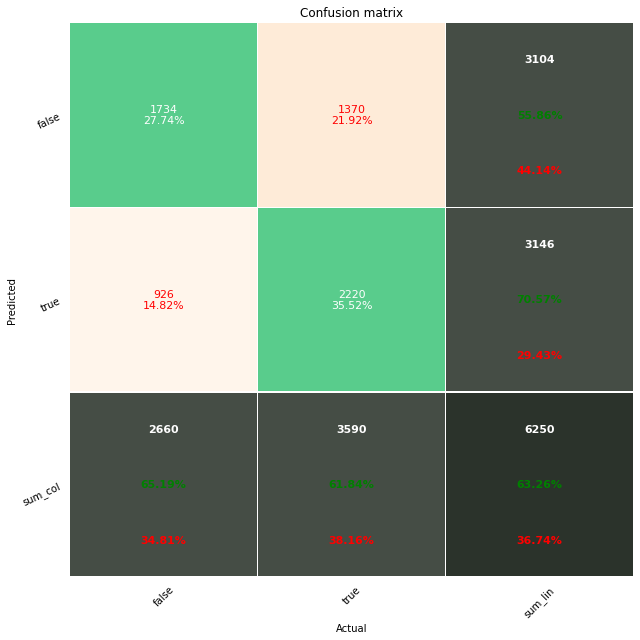

###########################################
precision: [0.55863402 0.70565798]
recall: [0.6518797 0.6183844]
fscore: [0.60166551 0.65914489]
support: [2660 3590]
###########################################3
Macro F1  0.6304052015870478
Micro F1  0.63264


In [ ]:
#naive bayes
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
clfNB = MultinomialNB()

scaler = MinMaxScaler()
scaledTrainX= scaler.fit_transform(trainReviewVectors)
scaledTestX = scaler.fit_transform(testReviewVectors)
clfNB.fit(scaledTrainX, trainLabels)

#test naive bayes accuracy
testLabelsPredicted=list(clfNB.predict(scaledTestX))

#print results
print("####################RESULTS OF NAIVE BAYES CLASSIFIER##################")
printResults(testLabelsPredicted, testLabels)
